In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
from IPython.display import Image

# **Introduction**

# **Debugging Workflow**

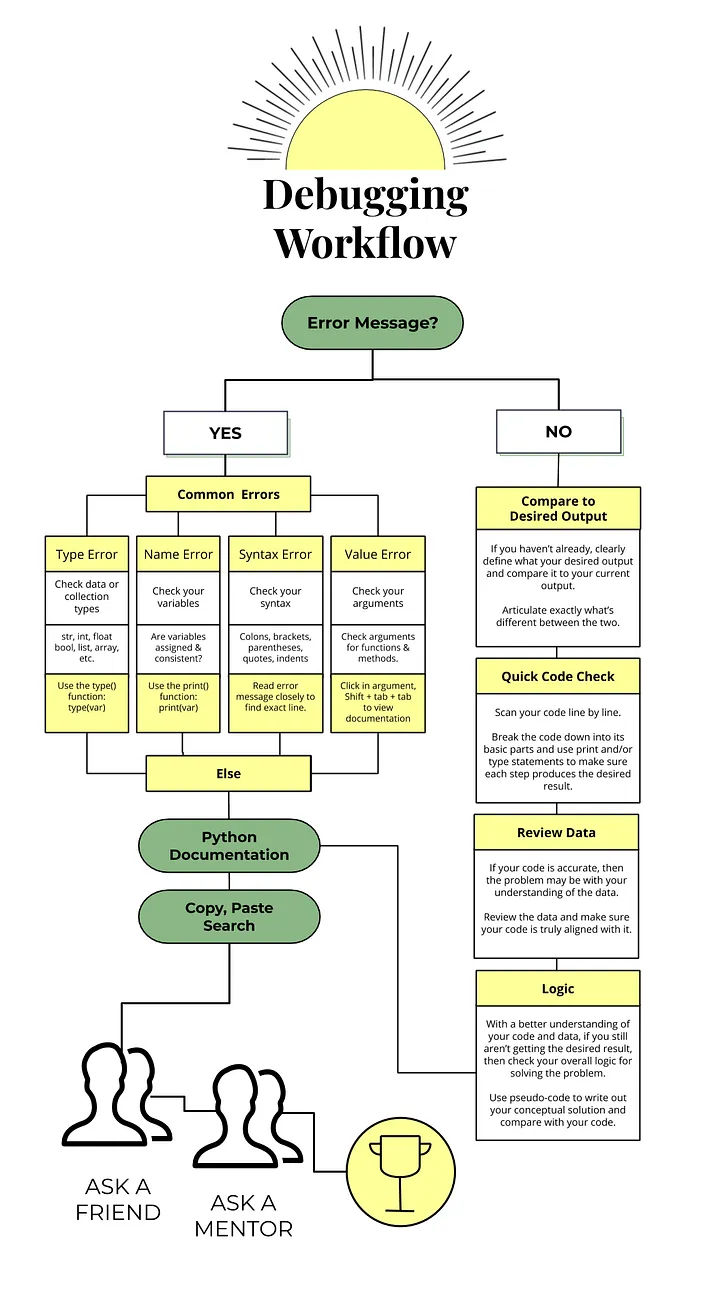

In [2]:
Image(filename='debugging_workflow.png') 

Image credit: Frank Flavell, https://medium.com/@mfflavell/debugging-checklist-for-python-beginners-d3719b8e7e6d

## Strategies

# **Examples of Common Errors**

Edit the code below to fix the errors. 

## Type Error

In [3]:
x = '3'
y = 2
z = x+y

print(z)

TypeError: can only concatenate str (not "int") to str

In [4]:
for i, j in range(1,5):
    print(i)

TypeError: cannot unpack non-iterable int object

## Name Error

In [5]:
b = 5
a = b + c

NameError: name 'c' is not defined

## Syntax Error 

In [6]:
for x in range(1,5)
print('x')

SyntaxError: invalid syntax (1709126299.py, line 1)

## Value Error

In [7]:
np.sqrt()

ValueError: invalid number of arguments

In [8]:
array = [[0],[1]]
for n in np.random.choice(array, size=5):
    print(n)

ValueError: a must be 1-dimensional

## Index Error

In [9]:
n = [1,2,3,4,5]
print(n[7])

IndexError: list index out of range

## Module Not Found Error

In [10]:
import cartapy

ModuleNotFoundError: No module named 'cartapy'

In [11]:
# There is no module named maps, so just comment out this line
from cartopy import maps

ImportError: cannot import name 'maps' from 'cartopy' (/Users/gecl1519/opt/miniconda3/envs/regrid_env/lib/python3.7/site-packages/cartopy/__init__.py)

## Attribute Error

In [12]:
np.squareroot(9)

AttributeError: module 'numpy' has no attribute 'squareroot'

# **Puzzles**

## Puzzle #1

We want to calculate the ocean net primary productivity (NPP), which is the rate at which carbon is converted from CO2 into organic matter through photosynthesis. In the ocean, phytoplankton are responsible for most of the photosynthesis, so maps of NPP tell us where phytoplankton are the most productive. The pigment that gives phytoplankton their green color is called chlorophyll, which can be seen from satellite instruments. 

To make a map of global NPP, your research advisor has given you the data (in a netCDF file) and the equations that you'll need. Our netCDF file contains satellite-derived chlorophyll (chl), sea surface temperature (sst), and photosynthetically active radiation (par — the amount of light available for photosynthesis) from October 1997.

We will use the Behrenfeld and Falkowski (1997) Vertically Generalized Production Model:
$NPP = chl * C\_opt * day\_length * par * z\_eu $

From this equation, we see that we also need to know the optimal carbon uptake (C_opt) and the depth of the euphotic zone (z_eu - the depth where photosynthesis is no longer possible becuase it is too dark). Luckily, your advisor has provided you with two functions (`calc_C_opt` and `calc_z_eu`) that will help you calculate these variables. For simplicity, we will assume that `day_length` is 12 hours globally.

Now we just need to apply these functions to our data!

#### Import Data

In [13]:
# Original code: 
# ds = xr.open_dataset('python_bootcamp/Day_9_Debugging/chlorophyll_data.nc')

# Updated code: 
ds = xr.open_dataset('chlorophyll_data_1deg.nc')

**What caused this error?** <br>
Your answer: We provided the incorrect file path for our data, so xarray wasn't able to find it. 

Hint: When you run into this type of error, try running `!pwd` in an empty cell to see which directory your notebook is running in, then figure out how to navigate from there to your data.

#### Look at the Data

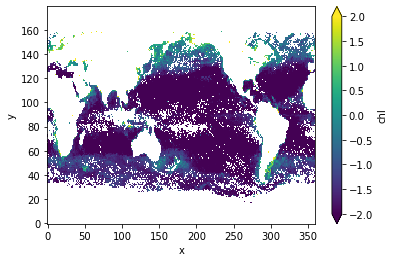

In [14]:
np.log(ds.chl).plot(cmap = 'viridis', vmax = 2)

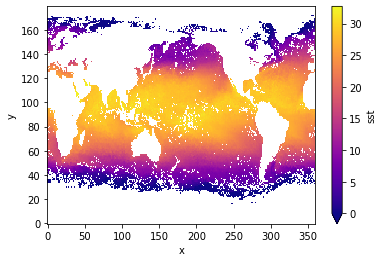

In [15]:
ds.sst.plot(vmin = 0, cmap = 'plasma')

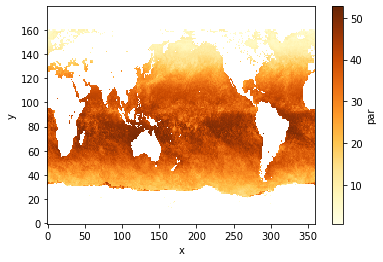

In [16]:
ds.par.plot(cmap = 'YlOrBr')

#### Functions

In [ ]:
def calc_C_opt(sst):

    if sst < -10.0:
        C_opt = 0.00
    elif sst <  -1.0:
        C_opt = 1.13 
    elif sst > 28.5: 
        C_opt = 4.00
    else:
        C_opt = 1.2956 + 2.749e-1*sst + 6.17e-2*sst**2 - 2.05e-2*sst**3 \
        + 2.462e-3*sst**4 - 1.348e-4*sst**5 + 3.4132e-6*sst**6 - 3.27e-8*sst**7
  
    return C_opt

In [ ]:
# Original code: 
# def calc_z_eu(chl):

#     if chl < 1:
#         chl_tot = 38.0*chl**0.425
#     else:
#         chl_tot = 40.2*chl**0.507

#     z_eu = 200.0*chl_tot**-.293

#     if z_eu <= 102.0:
#         z_eu = 568.2*chl_tot**-.746
        
# Updated code: 
def calc_z_eu(chl):

    if chl < 1:
        chl_tot = 38.0*chl**0.425
    else:
        chl_tot = 40.2*chl**0.507

    z_eu = 200.0*chl_tot**-.293

    if z_eu <= 102.0:
        z_eu = 568.2*chl_tot**-.746
    
    return z_eu

#### Apply Functions

In [ ]:
# Original code: 
# C_opt = calc_C_opt(ds.sst)
# z_eu = calc_z_eu(ds.chl)

# Updated code:
# apply function on sst DataArray
C_opt = xr.apply_ufunc(
             calc_C_opt,
             ds.sst,
             vectorize=True) 
# rename DataArray
C_opt = C_opt.rename('C_opt')

# apply function on chl DataArray
z_eu = xr.apply_ufunc(
             calc_z_eu,
             ds.chl,
             vectorize=True) 
# rename DataArray
z_eu  = z_eu.rename('z_eu')

On no! Our function doesn't work. Let's follow our debugging steps to figure our what is going on.

**What kind of error is this?** <br>
Answer: This is a Value Error, meaning we should check the arguments in our function

**What type of input does our function require?** <br>
(Hint: look at how the inputs are used in the function)  <br>
Your answer: float

**What data type are we trying to use?** <br>
(Hint: try `type(ds.chl)`) <br>
Your answer: xarray.DataArray

**Solution:** <br>
We need to figure out how to apply our function to every grid cell in our array.

Note: This is just one example of how you could do this. The `apply_ufunc` function is a bit tricky, so don't worry about the details right now. The important point here is that we can run into errors when trying to apply our function to an array. Here, that happened because we tried to use apply a conditional (`if`) statement to the entire array, which makes the desired result is unclear (i.e. given x = [3,10,2,1], x > 7 is true for some values but not others).

For applying a function over a pandas dataframe, see the `apply` method: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html. 

In [ ]:
npp = ds.chl * C_opt * 12 * (0.66125*ds.par/(ds.par + 4.1 )) * z_eu

**What kind of error is this?** <br>
Answer: This is a Type Error, so we should check our data types. In the error message, we see that we are trying to multiply a float by NoneType (meaing no data). But where is this NoneType data coming from? We'll have to check each one of our inputs to find it. One way to quickly check is to try plotting the DataArray using the `.plot()` method (you will get an error if you try to plot NoneType data)

**Which variable was the issue?** <br>
Your answer: z_eu

**What code could have caused this to happen, and how can we fix it to get the expected result?** <br>
Your answer: We forgot to add the `return` statement to our `calc_z_eu` function, so it returned nothing!

Once your code is working, let's plot the result!

In [ ]:
# units: molC m-2 yr-1
npp.plot(figsize = (10,6), vmax = 1000)